In [111]:
import numpy as np
import pandas as pd 
data = pd.read_parquet("clean.parquet")

pd.set_option('display.max_rows', 200)  # Replace 10 with your desired limit


In [108]:
data.head()

,time,location,consumption,temperature,temperature_mean_lag_1h,temperature_mean_lag_3h,temperature_mean_lag_6h,date_of_prediction,consumption-lag_5d,consumption-lag_6d,...,consumption-5_mean_lag_3d,consumption-5_mean_lag_7d,consumption-5_mean_lag_14d,temperature_mean_lag_1d,temperature_mean_lag_3d,temperature_mean_lag_7d,temperature_mean_lag_14d,day_of_week,day_of_year,hour_of_day
0,2022-04-26 00:00:00,bergen,0.583449,4.0,4.1,4.233333,6.166667,2022-04-25,0.643492,0.690125,...,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452,1,116,0
1,2022-04-26 01:00:00,bergen,0.597281,3.3,4.0,4.033333,5.133333,2022-04-25,0.643492,0.690125,...,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452,1,116,1
2,2022-04-26 02:00:00,bergen,0.592792,2.9,3.3,3.800000,4.350000,2022-04-25,0.643492,0.690125,...,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452,1,116,2
3,2022-04-26 03:00:00,bergen,0.604434,2.9,2.9,3.400000,3.816667,2022-04-25,0.643492,0.690125,...,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452,1,116,3
4,2022-04-26 04:00:00,bergen,0.664663,2.6,2.9,3.033333,3.533333,2022-04-25,0.643492,0.690125,...,0.691429,0.783495,0.903526,8.583333,9.711111,10.855357,9.243452,1,116,4


Lets try best subset selection with linear regression.

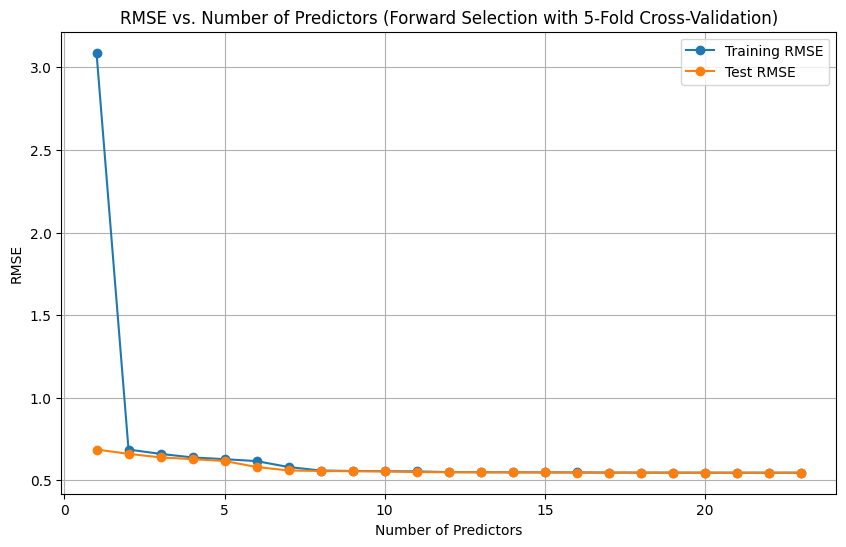

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load your dataset here (replace 'your_data.csv' with your actual dataset)
# Example:
# df = pd.read_csv('your_data.csv')
usefull_features = [c for c in data if c not in ("time","date_of_prediction")]
df = data[usefull_features]
# Split your data into features (X) and target (y)
X = df.drop(columns=['consumption'])  # Replace 'target_column' with your actual target column name
y = df['consumption']

# Initialize lists to store results
selected_predictors = []
train_rmse_values = []
test_rmse_values = []

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Create a Linear Regression model
model = LinearRegression()

# Forward selection loop
for i in range(1, X.shape[1] + 1):
    remaining_predictors = [p for p in X.columns if p not in selected_predictors]
    best_predictor = None
    best_avg_test_rmse = float('inf')

    for predictor in remaining_predictors:
        predictors_to_test = selected_predictors + [predictor]
        train_rmse_list = []
        test_rmse_list = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Fit the model and make predictions
            model.fit(X_train[predictors_to_test], y_train)
            y_train_pred = model.predict(X_train[predictors_to_test])
            y_test_pred = model.predict(X_test[predictors_to_test])

            # Calculate RMSE for training and test sets
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

            train_rmse_list.append(train_rmse)
            test_rmse_list.append(test_rmse)

        # Average RMSE across folds
        avg_train_rmse = np.mean(train_rmse_list)
        avg_test_rmse = np.mean(test_rmse_list)

        # Select the best predictor based on test RMSE
        if avg_test_rmse < best_avg_test_rmse:
            best_avg_test_rmse = avg_test_rmse
            best_predictor = predictor

    # Break the loop if no new predictor improves the model
    if best_predictor is None:
        break

    selected_predictors.append(best_predictor)
    train_rmse_values.append(avg_train_rmse)
    test_rmse_values.append(best_avg_test_rmse)

# Plot RMSE vs. Number of Predictors for both training and test sets
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selected_predictors) + 1), train_rmse_values, marker='o', linestyle='-', label='Training RMSE')
plt.plot(range(1, len(selected_predictors) + 1), test_rmse_values, marker='o', linestyle='-', label='Test RMSE')
plt.title('RMSE vs. Number of Predictors (Forward Selection with 5-Fold Cross-Validation)')
plt.xlabel('Number of Predictors')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print("Selected Features: ", selected_features)
print("Number of Features: ", sfs.k_feature_idx_)
print("Indices of Selected Features: ", sfs.k_feature_idx_)
print("Best Score (MSE): ", -sfs.k_score_)
print("Number of Cross-Validation Folds: ", sfs.cv)

print(data.columns)
selected_features

NameError: name 'selected_features' is not defined

I meeeean, it removed the locations, and some of the correlated variables. Does this mean that the locations do not matter to much, or that a linear predictor cant capture the relationship?

In [52]:

from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=100)

for train_idx, test_idx in gss.split(data, groups=data["time"].dt.date):
    df_train = data.iloc[train_idx]
    df_test = data.iloc[test_idx]

df_train.dtypes

time                          datetime64[ns]
location                              object
consumption                          float64
temperature                          float64
temperature_mean_lag_1h              float64
temperature_mean_lag_3h              float64
temperature_mean_lag_6h              float64
date_of_prediction                    object
consumption-lag_5d                   float64
consumption-lag_6d                   float64
consumption-lag_7d                   float64
consumption-5_mean_lag_3d            float64
consumption-5_mean_lag_7d            float64
consumption-5_mean_lag_14d           float64
temperature_mean_lag_1d              float64
temperature_mean_lag_3d              float64
temperature_mean_lag_7d              float64
temperature_mean_lag_14d             float64
day_of_week                            int64
day_of_year                            int64
hour_of_day                            int64
dtype: object

In [57]:
from autogluon.tabular import TabularPredictor

In [70]:

usefull_features = [c for c in data if c not in ("time","date_of_prediction")]
usefull_features_test = [c for c in usefull_features if c not in ("consumption")]
train = df_train[usefull_features]
test = df_test[usefull_features]


hyperparameters = {
    'GBM':{}, 
    'CAT':{}, 
    'RF':{}, 
    'XT':{}}

predictor_medium = TabularPredictor(label='consumption',eval_metric='mean_absolute_error').fit(
    train_data=train, 
    presets="medium_quality_faster_train",
    num_bag_folds=8,
    num_stack_levels=0,
    excluded_model_types = {"KNN","NN_TORCH","FASTAI"}
)

No path specified. Models will be saved in: "AutogluonModels\ag-20231114_120537\"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231114_120537\"
AutoGluon Version:  0.8.2
Python Version:     3.9.6
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   590.54 GB / 1022.87 GB (57.7%)
Train Data Rows:    37476
Train Data Columns: 19
Label Column: consumption
Preprocessing data ...


AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (18.031449, 0.3817069999999999, 3.61172, 3.15654)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4190.84 MB
	Train Data (Original)  Memory Usage: 8.98 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fit

In [72]:
#predictor = TabularPredictor.load("AutogluonModels\ag-20231114_120537\")
predictor_medium.leaderboard()

                    model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2  -0.039500     375.913007  1679.017885                0.001019           0.526702            2       True          8
1         LightGBM_BAG_L1  -0.042101      91.645438    65.909635               91.645438          65.909635            1       True          2
2    LightGBMLarge_BAG_L1  -0.042404     126.441512   137.841117              126.441512         137.841117            1       True          7
3          XGBoost_BAG_L1  -0.047656      48.625025   128.992011               48.625025         128.992011            1       True          6
4         CatBoost_BAG_L1  -0.048141       0.182998  1280.807896                0.182998        1280.807896            1       True          4
5       LightGBMXT_BAG_L1  -0.051222     109.017015    64.940525              109.017015          64.940525            1       True          1

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.039500,375.913007,1679.017885,0.001019,0.526702,2,True,8
1,LightGBM_BAG_L1,-0.042101,91.645438,65.909635,91.645438,65.909635,1,True,2
2,LightGBMLarge_BAG_L1,-0.042404,126.441512,137.841117,126.441512,137.841117,1,True,7
3,XGBoost_BAG_L1,-0.047656,48.625025,128.992011,48.625025,128.992011,1,True,6
4,CatBoost_BAG_L1,-0.048141,0.182998,1280.807896,0.182998,1280.807896,1,True,4
5,LightGBMXT_BAG_L1,-0.051222,109.017015,64.940525,109.017015,64.940525,1,True,1
6,ExtraTreesMSE_BAG_L1,-0.065108,1.392994,6.018528,1.392994,6.018528,1,True,5
7,RandomForestMSE_BAG_L1,-0.067842,1.439000,17.713079,1.439000,17.713079,1,True,3


In [ ]:
info = predictor_medium.info()
ensemble_info = info['model_info']['WeightedEnsemble_L2']['child_model_weights']
print(ensemble_info)

In [78]:
test = df_test[usefull_features]
X_test = test.drop(columns=["consumption"])
y_test = test["consumption"]

pred = predictor_medium.predict(X_test)

In [103]:
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae
mae(pred,y_test)

0.11328640468848226